# **Description**
In this notebook you will firstly train a CNN on cifar10 dataset. The CNN architecture is provided in ``` resnet.py ```. Then you are going to immplement targeted and untargeted FGSM attack and also $l_{∞}$-PGD attack, and evaluate the performance of the trained model on the adversarial data.


**Attention!** Make sure you do not miss the questions asked at the end of the notebook.






#**Setups**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#feel free to change the path if needed

%cd '/content/drive/MyDrive/DL_HW5'

/content/drive/MyDrive/DL_HW5


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import matplotlib.pyplot as plt
import numpy as np

from resnet import *

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
'''
These are the default values for variables, these should work, but if needed, you are allowed to change these parameters.
'''

batch_size = 128
lr = 1e-3
epochs = 100

In [6]:
print('==> Preparing data..')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


###################################################
#prepare training and test datasets and loaders   #
###################################################



######################
# Your code goes here
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


#**Building The Model**

In [7]:
########################################
#build your model                      #
########################################
print('==> Building model..')
net = ResNet18()
net = net.to(device)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

==> Building model..


In [8]:
# Training
def train(epoch, net, optimizer, trainloader):
    print('\nEpoch: %d' % epoch)
    net.train()
    criterion = nn.CrossEntropyLoss()

    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return train_loss/len(trainloader), 100*correct/total


def test(epoch, net, testloader):
    net.eval()
    criterion = nn.CrossEntropyLoss()

    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss/len(testloader), 100 * correct / total

In [9]:
######################################################################
#train your model, make sure to save loss and accuracy in all epochs #
######################################################################

######################
# Your code goes here
total_train_loss =[]
final_train_accuracy = []
total_test_loss =[]
final_test_accuracy = []

for epoch in range(epochs):
  loss ,acc = train(epoch, net, optimizer, trainloader)
  total_train_loss.append(loss)
  final_train_accuracy.append(acc)
  print('loss',loss,'accuracy', acc)

  loss_test ,acc_test = test(epoch, net, testloader)
  total_test_loss.append(loss_test)
  final_test_accuracy.append(acc_test)
  print('loss_test',loss_test,'acc_test', acc_test)


Epoch: 0
loss 1.603803006279499 accuracy 40.678
loss_test 1.2928270539150963 acc_test 52.78

Epoch: 1
loss 1.1798238217678216 accuracy 57.086
loss_test 1.3063771015481105 acc_test 56.48

Epoch: 2
loss 0.968940784406784 accuracy 65.478
loss_test 0.9148246683651888 acc_test 68.07

Epoch: 3
loss 0.8304644252942956 accuracy 70.482
loss_test 0.8497619530822658 acc_test 70.65

Epoch: 4
loss 0.7308057454388465 accuracy 74.406
loss_test 0.9028634919395929 acc_test 69.33

Epoch: 5
loss 0.6516602654438799 accuracy 77.204
loss_test 0.9826318787623055 acc_test 68.85

Epoch: 6
loss 0.5958204442430335 accuracy 79.442
loss_test 0.7302405804018431 acc_test 75.62

Epoch: 7
loss 0.549706382062429 accuracy 80.694
loss_test 0.6440508090242555 acc_test 78.99

Epoch: 8
loss 0.5093409165244578 accuracy 82.24
loss_test 0.5929237343842471 acc_test 79.68

Epoch: 9
loss 0.4779883971452103 accuracy 83.422
loss_test 0.5724685365640665 acc_test 80.46

Epoch: 10
loss 0.4472456152176918 accuracy 84.52
loss_test 0.54

In [10]:
########################################
#save your model and history           #
########################################
#torch.save(net.state_dict(), 'model.pt')
results = {'train_losses': total_train_loss, 'train_accs': final_train_accuracy, 'test_losses': total_test_loss, 'test_accs': final_test_accuracy}
torch.save({
            'model_state_dict': net.state_dict(),
            'train_losses': total_train_loss,
            'train_accs': final_train_accuracy,
            'test_losses':total_test_loss,
            'test_accs':final_test_accuracy
            },'drive')
######################
# Your code goes here

##**Train and Test Loss and Accuracy Plots**

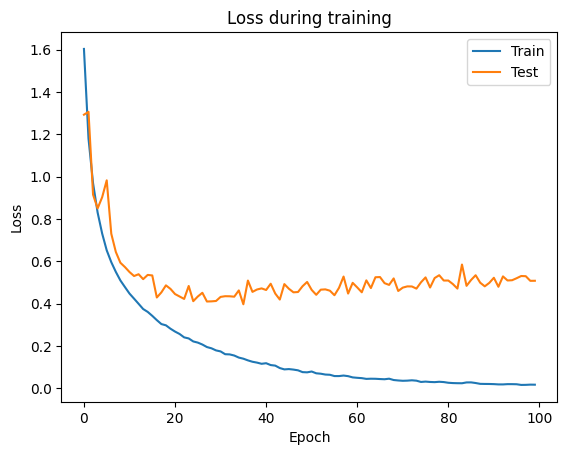

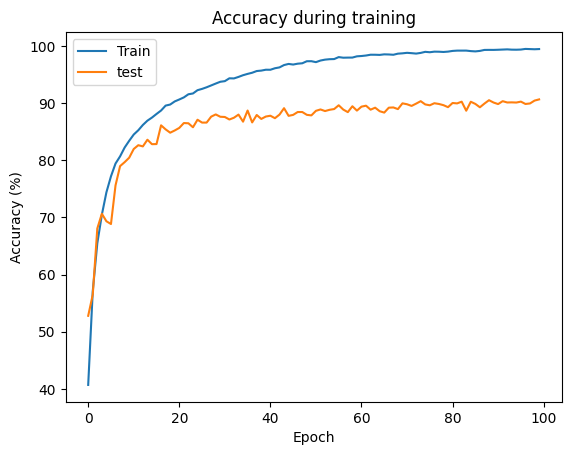

In [11]:
#############################################################
#plot train and test loss and accuracy dusring the training #
#############################################################

plt.plot(total_train_loss, label='Train')
plt.plot(total_test_loss, label='Test')
plt.title('Loss during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(final_train_accuracy, label='Train')
plt.plot(final_test_accuracy, label='test')
plt.title('Accuracy during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()
######################
# Your code goes here

##**Untargeted FGSM Attack**

In [12]:
########################################
#define untargeted FGSM attack         #
########################################
def FGSM (model, x, y, epsilon):
  """
  inputs:
    model: model to be attacked
    x: input image
    y: label
    epsilon: clipping threshold for FGSM

  outputs:
    x': the perturbed image
    delta: the added perturbation
    y': prediction of the model for the perturbed input
  """
  x.requires_grad = True
  output = model(x)
  model.zero_grad()
  loss = nn.CrossEntropyLoss()(output, y)
  loss.backward()
  #loss_ = torch.autograd.grad(loss.sum(), x)[0] #I got better results with the other method
  data_grad = x.grad.data
  delta = epsilon*data_grad.sign()

  return x+delta, delta, model(x+delta)


###**Evaluation**


 For $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on targeted FGSM attack on the test data.

In [13]:
  ######################
  # Your code goes here

epsilons = [1/255,4/255,8/255]
for epsilon in epsilons:
    test_loss = 0
    correct = 0
    total = 0
    print('\nepsilon:'  ,epsilon)
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs.requires_grad = True
        t_,t,y_ = FGSM(net, inputs, targets, epsilon)
        loss = nn.CrossEntropyLoss()(y_,targets)

        test_loss += loss.item()
        _, predicted = y_.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print('loss_test',test_loss/len(testloader),'acc_test', 100 * correct / total)


epsilon: 0.00392156862745098
loss_test 0.8379545800293549 acc_test 85.47

epsilon: 0.01568627450980392
loss_test 2.658353511291214 acc_test 64.74

epsilon: 0.03137254901960784
loss_test 6.277227534523493 acc_test 41.42


###**FGSM by gradually increasing $ϵ$**

FGSM attack may not work for small $\epsilon$, on the other hand we want to alter image as insignificant as possible, so here is what we do, we start from $\epsilon = \frac{1}{255}$ and if the attack was unsuccessful, we increase $\epsilon$ by $\frac{1}{255}$. The procedure goes on until the predicted label is different from the ground truth.

In [14]:
#######################################################
#increase epsilon gradually till the label is changed. The function can be implemented recursively.#
#######################################################

def generate_adversarial_FGSM (model, x, label, initial_epsilon=1/255):
  """
  inputs:
    model: model to be attacked
    x: input image
    y: label
    epsilon: intial clipping threshold for FGSM

  outputs:
    epsilon: the epsilon that flips the label.
    delta: the added perturbation
    y': prediction of the model for the perturbed input
  """



  ######################
  # Your code goes here
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  delta = torch.tensor([0]).to(device)
  x.requires_grad = True
  output_ = model(x)
  if output_.max(1)[1]  != label: # So if the model doesn't predict the correct label the attack won't be perform performed
    return initial_epsilon, delta, model(x+delta)
  model.zero_grad()
  loss = nn.CrossEntropyLoss()(output_, label)
  loss.backward()
  data_grad = x.grad.data
  sign_grad = data_grad.sign()#I calculated this here so the loop won't be forced to caclulate it in each step
  delta = initial_epsilon*sign_grad
  attacked_output = model(x+delta)
  epsilon = initial_epsilon
  while True:
    if  attacked_output.max(1)[1]  != label:
      return epsilon, delta, model(x+delta)

    epsilon += initial_epsilon
    delta = epsilon*sign_grad
    attacked_output = model(x+delta)



### **Visualization**
Pick 10 samples from cifar10 test set, each from one class, make sure the selected samples are classified correctly. Plot these samples. Take note that the selected data must not be transformed by train or test transformations while visualisation.

Files already downloaded and verified


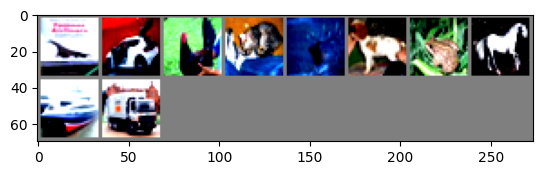

In [15]:
#############################################################################################
#visualize one test sample from each class and make sure that they are correctly labeled.   #
#save index of these samples, since they are needed in the following sections.              #
#############################################################################################

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()





#######################
# Your code goes here
testset_= torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform_test)
testloader_ = torch.utils.data.DataLoader(testset_, batch_size=1000,shuffle=False)


dataiter = iter(testloader_)
images, labels = next(dataiter)

dict_classes = testset_.class_to_idx
reverse_dict = {v: k for k, v in dict_classes.items()}

index = np.arange(10)
images_ = []
for i in index:
    for j in range(images.shape[0]):
      if labels[j] == i:
        images_.append(images[j])
        break;

imshow(torchvision.utils.make_grid(images_))
print(' '.join(f'{reverse_dict[j]:5s}' for j in range(10)))


Now, apply untargetted FGSM attack ``` generate_adversarial_FGSM ``` on the selected samples. Visualize the original image, the perturbed image, and the perturbation. since the perturbation is imperceptible, magnify it by the value of $\frac{1}{\epsilon}$ before visualization.

airplane automobile bird  cat   deer  dog   frog  horse ship  truck


normal_shot with class label of airplane


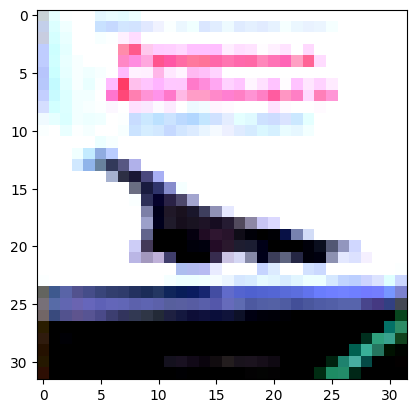

attacked_shot with predicted class label of truck


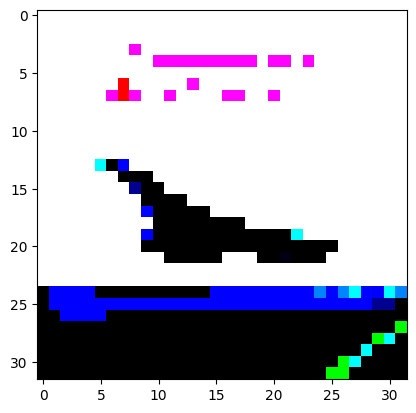

normal_shot with class label of automobile


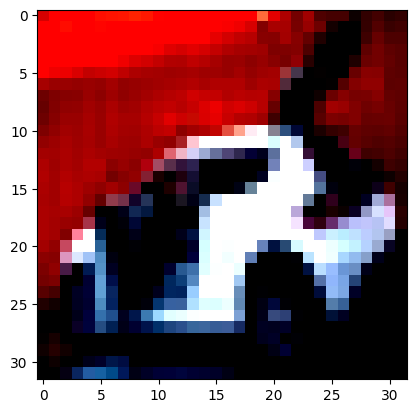

attacked_shot with predicted class label of cat


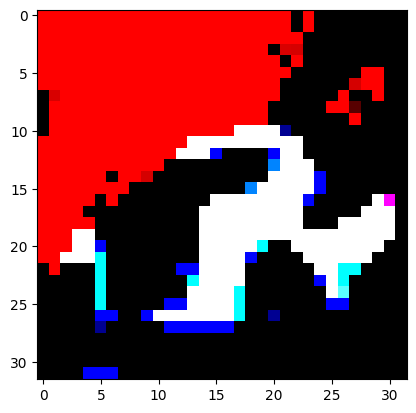

normal_shot with class label of bird


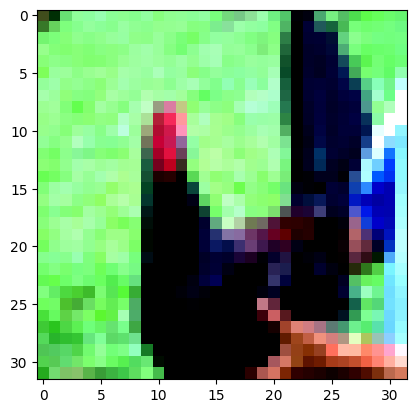

attacked_shot with predicted class label of deer


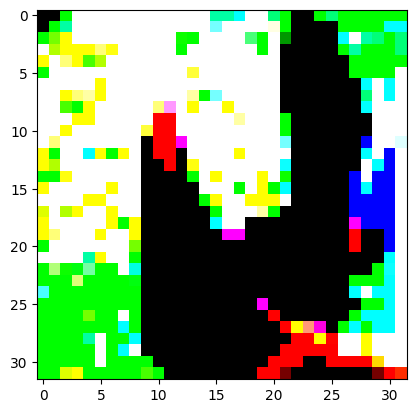

normal_shot with class label of cat


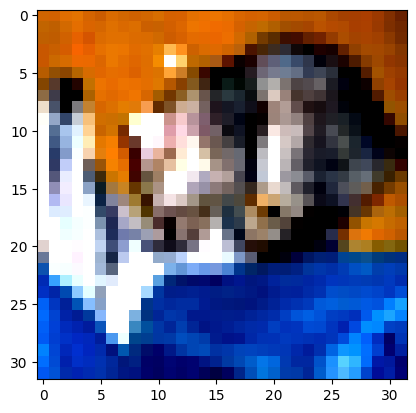

attacked_shot with predicted class label of dog


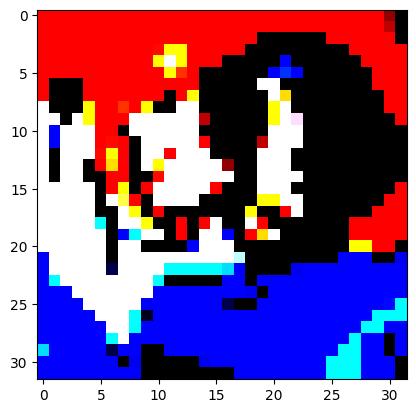

normal_shot with class label of deer


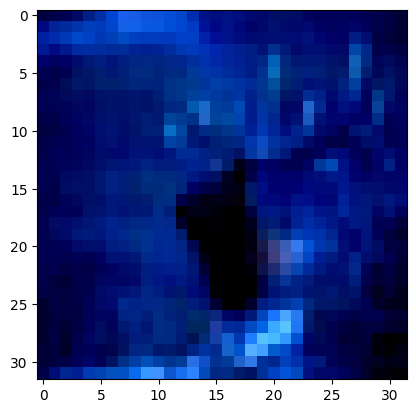

attacked_shot with predicted class label of airplane


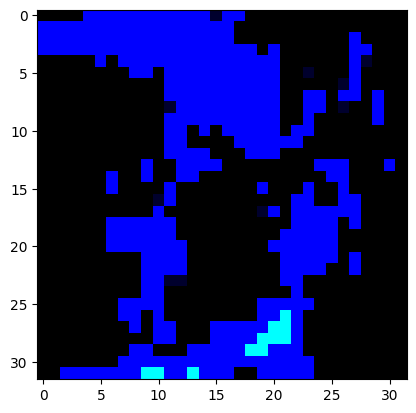

normal_shot with class label of dog


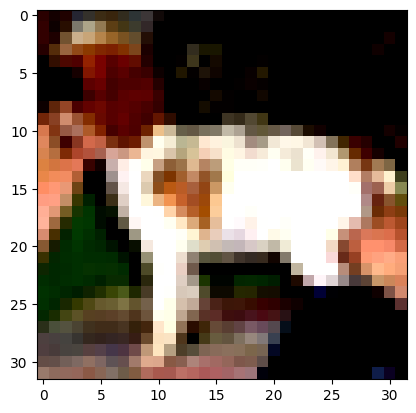

attacked_shot with predicted class label of deer


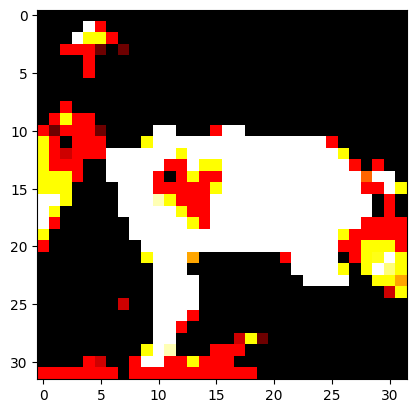

normal_shot with class label of frog


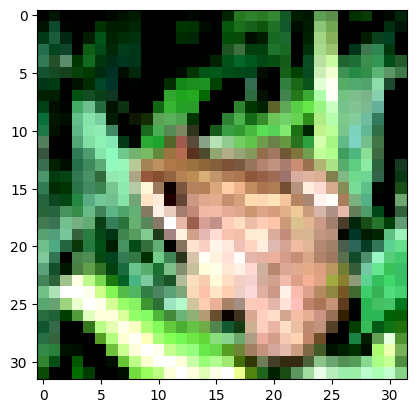

attacked_shot with predicted class label of bird


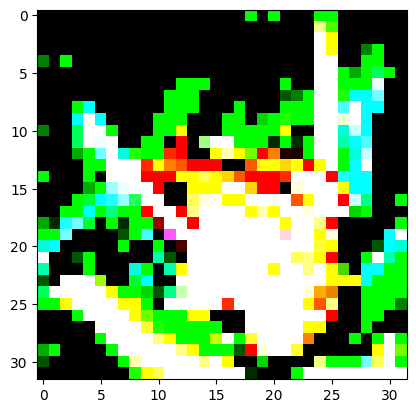

normal_shot with class label of horse


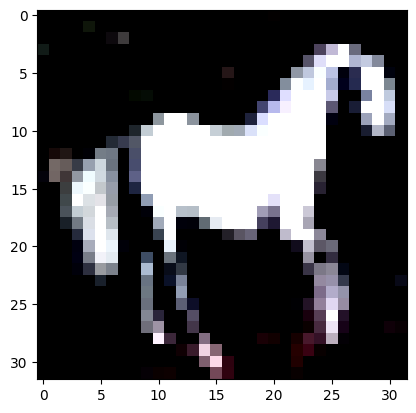

attacked_shot with predicted class label of deer


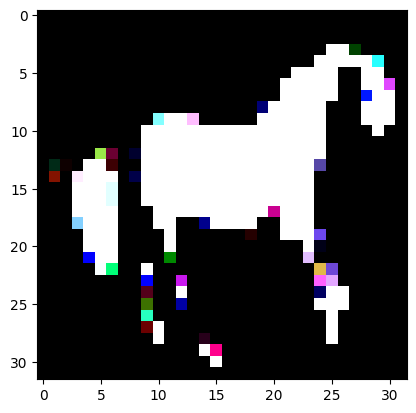

normal_shot with class label of ship


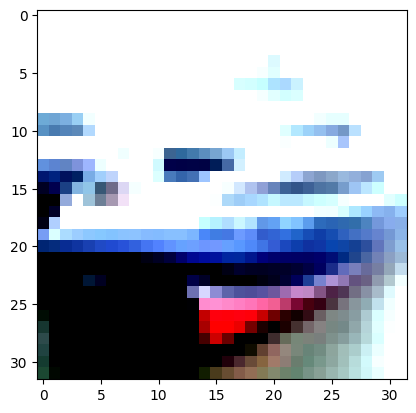

attacked_shot with predicted class label of automobile


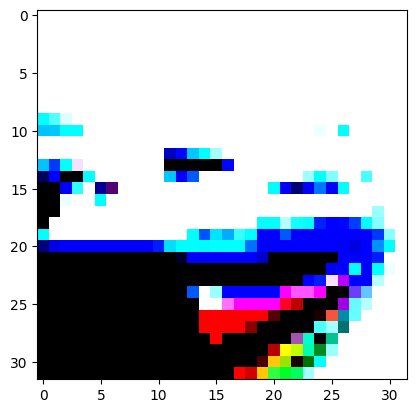

normal_shot with class label of truck


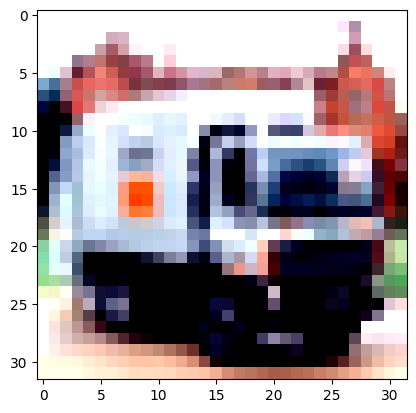

attacked_shot with predicted class label of automobile


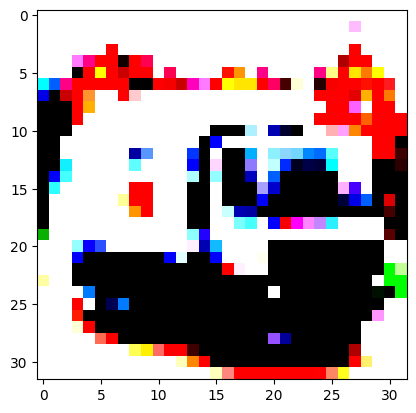

In [16]:
######################################################################################################
#visualize the selected samples, their corresponding perturbed image, and the magnified perturbation #
#also print the ground truth and the predicted label for each sample                                 #
######################################################################################################

######################
# Your code goes here

for x ,label in zip(images_,index):

  epsilon, delta, output_attacked = generate_adversarial_FGSM(net, x.unsqueeze(0).to(device), torch.tensor(label).unsqueeze(0).to(device), initial_epsilon=1/255)
  print('normal_shot with class label of', reverse_dict[label])
  imshow(torchvision.utils.make_grid(x))
  plt.show()
  print('attacked_shot with predicted class label of',reverse_dict[output_attacked.max(1)[1].detach().cpu().numpy()[0]] )
  imshow(torchvision.utils.make_grid((1/epsilon)*(x.cpu() + delta.cpu())))
  plt.show()




```
# This is formatted as code
```

##**Targeted FGSM Attack**
implement targeted FGSM attack.

In [17]:
  ########################################
#define tergeted FGSM attack           #
########################################

def FGSM_targeted (model, x, y, y_targ, epsilon):
    """
    inputs:
    model: model to be attacked
    x: input image
    y: label
    y_targ = target label
    epsilon: clipping threshold for FGSM

    outputs:
    x': the perturbed image
    delta: the added perturbation
    """


  ######################
  # Your code goes here

    x.requires_grad = True
    output = model(x)
    model.zero_grad()
    loss = nn.CrossEntropyLoss()(output, y_targ)
    model.zero_grad()
    loss.backward()
    data_grad = x.grad.data
    delta = epsilon*data_grad.sign()
    x_adv = x + delta
    x_adv = torch.clamp(x_adv, 0, 1)

    return x_adv, delta


###**Evaluation**
for each sample, select the most probable lable as the target label (if the most probable label is the ground truth, select the second most probable label). For $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on targeted FGSM attack on the test data.

In [18]:
######################
# Your code goes here
epsilons = [1/255,4/255,8/255]
total_acc_0 = []
for epsilon in epsilons:
    test_loss = 0
    correct = 0
    total = 0
    print('\nepsilon:'  ,epsilon)
    each_eps_acc = []
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs.requires_grad = True

        output = net(inputs)
        sorted_values, sorted_indices = torch.sort(output, descending=True)

        most_probable = []
        mask =  (targets == sorted_indices[:,0])
        for i in range(len(mask)):
          if mask[i]:
            most_probable.append(sorted_indices[i,1])
          else:
            most_probable.append(sorted_indices[i,0])
        most_probable = torch.stack(most_probable)

        x_adv, delta = FGSM_targeted(net, inputs, targets,most_probable, epsilon)

        y_ = net(x_adv)


        loss = nn.CrossEntropyLoss()(y_,targets)

        test_loss += loss.item()

        _, predicted = y_.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        each_eps_acc.append(100 * correct / total)
    print('loss_base_on_true_label_and_predicted_label',test_loss/len(testloader),'acc_test', 100 * correct / total)
    total_acc_0.append(each_eps_acc)


epsilon: 0.00392156862745098
loss_base_on_true_label_and_predicted_label 3.5493280917783325 acc_test 52.18

epsilon: 0.01568627450980392
loss_base_on_true_label_and_predicted_label 3.326604085632517 acc_test 55.12

epsilon: 0.03137254901960784
loss_base_on_true_label_and_predicted_label 3.0914836412743676 acc_test 58.0




```
# This is formatted as code
```

for each sample, select the least probable lable as the target label (if the least probable label is the ground truth, select the second most probable label). For $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on targeted FGSM attack on the test data.

In [19]:
######################
# Your code goes here
epsilons = [1/255,4/255,8/255]
total_acc = []

for epsilon in epsilons:
    test_loss = 0
    correct = 0
    total = 0
    print('\nepsilon:'  ,epsilon)
    each_eps_acc = []
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs.requires_grad = True

        output = net(inputs)
        sorted_values, sorted_indices = torch.sort(output, descending=True)

        most_probable = []
        mask =  (targets == sorted_indices[:,-1])
        for i in range(len(mask)):
          if mask[i]:
            most_probable.append(sorted_indices[i,-2])
          else:
            most_probable.append(sorted_indices[i,-1])
        most_probable = torch.stack(most_probable)

        x_adv, delta = FGSM_targeted(net, inputs, targets,most_probable, epsilon)

        y_ = net(x_adv)


        loss = nn.CrossEntropyLoss()(y_,targets)

        test_loss += loss.item()

        _, predicted = y_.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        each_eps_acc.append(100 * correct / total)
    print('loss_base_on_true_label_and_predicted_label',test_loss/len(testloader),'acc_test', 100 * correct / total)
    total_acc.append(each_eps_acc)


epsilon: 0.00392156862745098
loss_base_on_true_label_and_predicted_label 3.573878487454185 acc_test 51.99

epsilon: 0.01568627450980392
loss_base_on_true_label_and_predicted_label 3.4141424486908734 acc_test 54.22

epsilon: 0.03137254901960784
loss_base_on_true_label_and_predicted_label 3.245680839200563 acc_test 56.56


plot accuracy of model with respect to $\epsilon$ both for least probable and most probable target labels (both in a single plot).

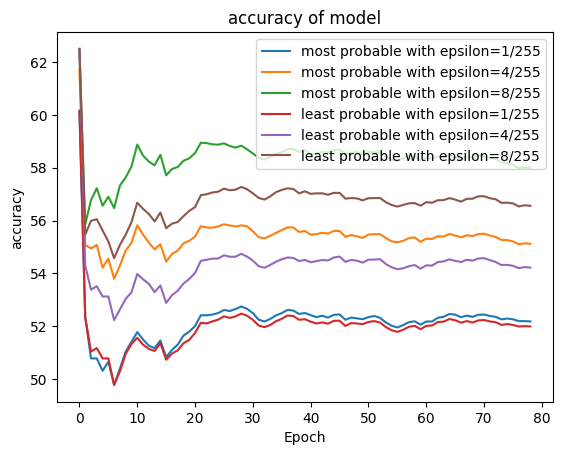

In [20]:
######################
# Your code goes here

plt.plot(total_acc_0[0], label='most probable with epsilon=1/255')
plt.plot(total_acc_0[1], label='most probable with epsilon=4/255')
plt.plot(total_acc_0[2], label='most probable with epsilon=8/255')
plt.plot(total_acc[0], label='least probable with epsilon=1/255')
plt.plot(total_acc[1], label='least probable with epsilon=4/255')
plt.plot(total_acc[2], label='least probable with epsilon=8/255')
plt.title('accuracy of model')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

#**PGD Attack (30 pts)**

Implement PGD attack in the following cell. There is no need to change the default $\epsilon$ and $\alpha$.

In [21]:
def PGD (model, x, y, iterations, epsilon=8/255, alpha=3/255):
  """
  inputs:
    model: model to be attacked
    x: input image
    y: label
    iterations: number of iterations for PGD attack
    epsilon: clipping threshold for PGD
    alpha: step size for PGD attack

  outputs:
    x': the perturbed image
    delta: the added perturbation
    y': prediction of the model for the perturbed input
  """

  delta = 0

  ######################
  # Your code goes here

  x.requires_grad = True

  for epoch in range(iterations):

    output = model(x + delta)
    model.zero_grad()
    loss = nn.CrossEntropyLoss()(output, y)
    loss.backward()
    delta += torch.sign(x.grad)
    delta = torch.clamp(delta, 0, epsilon)
    perturbed_input = x + alpha*delta

  return x+delta, delta, model(x+delta)


##**Evaluation**
for iterations $\in \{3, 7, 12\}$, evaluate performance of the model on adversarial test data.

In [22]:
######################
# Your code goes here
######################
# Your code goes here
iterations = [3,7,12]
for epoch in iterations:
    test_loss = 0
    correct = 0
    total = 0
    print('\niterations:'  ,epoch)
    each_eps_acc = []
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        x_, delta, y_ = PGD(net, inputs, targets, epoch)
        loss = nn.CrossEntropyLoss()(y_,targets)

        test_loss += loss.item()

        _, predicted = y_.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        each_eps_acc.append(100 * correct / total)
    print('loss_base_on_true_label_and_predicted_label',test_loss/len(testloader),'acc_test', 100 * correct / total)



iterations: 3
loss_base_on_true_label_and_predicted_label 3.09351093105123 acc_test 60.86

iterations: 7
loss_base_on_true_label_and_predicted_label 3.186123455627055 acc_test 59.74

iterations: 12
loss_base_on_true_label_and_predicted_label 3.201328091983554 acc_test 59.63


In [23]:
'''
1. Base on my observation bigger epsilon causes stronger attack which as a result the
accuracy of model is decreased
2.The most probable targetted FGSM attacks have higher test accuracy, this happens beacause
if we put least probable class in criterion we get larger loss value so as a result we have stronger attack
3.as we increase the total number of iterations test accuracy begin to decrease
this happens beacuase when we process over iteration the algorithm finds better attacks
4. PGD happens in one step but FGSM is iterative, PGD is a stronger attack for this model than FGSM. I compared test accuracy in
both cases from my results as shown earlier in code
'''

'\n1. Base on my observation bigger epsilon causes stronger attack which as a result the\naccuracy of model is decreased\n2.The most probable targetted FGSM attacks have higher test accuracy, this happens beacause\nif we put least probable class in criterion we get larger loss value so as a result we have stronger attack\n3.as we increase the total number of iterations test accuracy begin to decrease\nthis happens beacuase when we process over iteration the algorithm finds better attacks\n4. PGD happens in one step but FGSM is iterative, PGD is a stronger attack for this model than FGSM. I compared test accuracy in\nboth cases from my results as shown earlier in code\n'